# **Filtering and Trimming Messages**

**Review**

Now, we have a deeper understanding of a few things:

How to customize the graph state schema
How to define custom state reducers
How to use multiple graph state schemas

**Goals**

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [2]:
import os
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY']=GOOGLE_API_KEY

## **Messages as State**

First, let's define some messages.

In [3]:
# Define some messages
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Assitant")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Anas"))

for msg in messages:
  msg.pretty_print()

================================== Ai Message ==================================
Name: Assitant

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Anas

Yes, I know about whales. But what others should I learn about?


Now, we can pass them to a chat Model

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
model.invoke(messages)

AIMessage(content='Okay, great! Knowing about whales is a good start. Ocean mammals are a diverse group! Here\'s a breakdown of other types of ocean mammals you should learn about, along with some key features and examples:\n\n**1. Pinnipeds (Seals, Sea Lions, and Walruses):**\n\n*   **Key Features:**\n    *   "Fin-footed" (pinniped means "fin-footed")\n    *   Amphibious - spend time both on land and in the water.\n    *   Blubber for insulation.\n    *   Carnivorous, feeding on fish, squid, crustaceans, and other marine life.\n*   **Examples:**\n    *   **Seals:** Often lack external ear flaps, have shorter flippers, and move on land by wiggling their bodies.  (e.g., Harbor Seal, Grey Seal, Elephant Seal)\n    *   **Sea Lions:** Have external ear flaps, longer flippers, and can "walk" on their flippers on land. (e.g., California Sea Lion, Steller Sea Lion)\n    *   **Walruses:** Easily identifiable by their prominent tusks, whiskers, and large size. (e.g., Atlantic Walrus, Pacific Wa

We can run our chat model in a simple graph with MessagesState.

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

In [6]:
# Defining model node
def model_node(state: MessagesState) -> MessagesState:
  return {"messages": [model.invoke(state["messages"])]}

In [7]:
# Building our graph
builder = StateGraph(MessagesState)

# Add Nodes
builder.add_node("model_node", model_node)

# Add Edges
builder.add_edge(START, "model_node")
builder.add_edge("model_node", END)

# Compile
graph = builder.compile()

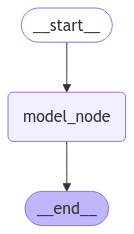

In [8]:
# Visualize
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Invoke
output = graph.invoke({"messages": messages})
for msg in output["messages"]:
  msg.pretty_print()

================================== Ai Message ==================================
Name: Assitant

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Anas

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Since you already know about whales, let's explore some other fascinating ocean mammals. Here are some categories and specific examples you might find interesting:

**1. Pinnipeds (Seals, Sea Lions, and Walruses):** These are characterized by having flippers for swimming.

*   **Seals:**
    *   **Harbor Seal:** Common and adaptable, found in many coastal regions.
    *   **Elephant Seal:** Massive! Known for their large noses and aggressive mating rituals.
    *   **Leopard Seal:** A top predator in Antarctica, known for hunting penguins and other seals.
*   **Sea Lions:**
    *   **California S

In [10]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Assitant', id='01cd51d6-5df2-42db-9eba-c12e8fac8a25'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Anas', id='d5a9e901-3128-4b54-96b5-5933a0f55211')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '88c351a9-09c4-40b1-85b8-585211f15cc0', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Assitant', id='01cd51d6-5df2-42db-9eba-c12e8fac8a25'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Anas', id='d5a9e901-3128-4b54-96b5-5933a0f55211')]}}, 'name': '__sta

## **Reducer**

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using **RemoveMessage** and the **add_messages** reducer.

In [11]:
from langchain_core.messages import RemoveMessage

In [12]:
# Defining Nodes
def filter_messages(state: MessagesState) -> MessagesState:
  delete_messages = [RemoveMessage(message.id) for message in state["messages"][:-2]]
  return {"messages": delete_messages}

def model_node(state: MessagesState) -> MessagesState:
  return {"messages": [model.invoke(state["messages"])]}

In [13]:
# Building the graph
builder = StateGraph(MessagesState)

# Add Node
builder.add_node("filter_messages", filter_messages)
builder.add_node("model_node", model_node)

# Add Edge
builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "model_node")
builder.add_edge("model_node", END)

# Compile
graph = builder.compile()

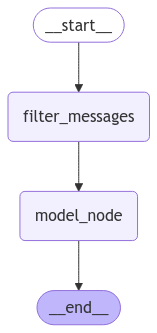

In [14]:
# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# Messages list with a premeable
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage("Hi.", name="Assistant", id="1")]
messages.append(HumanMessage("Hi.", name="Anas", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Assistant", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Anas", id="4"))

In [16]:
# Invoke
output = graph.invoke({"messages": messages})
for msg in output["messages"]:
  msg.pretty_print()

================================== Ai Message ==================================
Name: Assistant

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Anas

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Whales are a good starting point. To broaden your knowledge of ocean mammals, here are some other fascinating groups you should definitely learn about:

**1. Dolphins and Porpoises:**

*   **Why:** Often confused with whales, they are actually *toothed whales* but are generally smaller and more agile. They are incredibly intelligent and social animals.
*   **Things to research:** Different species (bottlenose, orca, harbor porpoise), their communication methods, their hunting strategies, and their conservation status.
*   **Fun Fact:** Dolphins use echolocation to navigate and find prey, emittin

## **Filtering Messages**

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: **llm.invoke(messages[-1:])** to the model.

In [17]:
# Node
def model_node(state: MessagesState) -> MessagesState:
  return {"messages": [model.invoke(state["messages"][-1:])]}

In [18]:
# Building graph
builder = StateGraph(MessagesState)

# Add Node
builder.add_node("model_node", model_node)

# Add Edge
builder.add_edge(START, "model_node")
builder.add_edge("model_node", END)

# compile
graph = builder.compile()

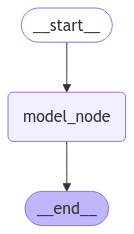

In [19]:
# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [20]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Anas"))

In [21]:
for msg in messages:
  msg.pretty_print()

================================== Ai Message ==================================
Name: Assistant

Hi.
================================ Human Message =================================
Name: Anas

Hi.
================================== Ai Message ==================================
Name: Assistant

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Anas

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Whales are a good starting point. To broaden your knowledge of ocean mammals, here are some other fascinating groups you should definitely learn about:

**1. Dolphins and Porpoises:**

*   **Why:** Often confused with whales, they are actually *toothed whales* but are generally smaller and more agile. They are incredibly intelligent and social animals.
*   **Things to research:** Different species (b

In [22]:
# Invoke using message filtering
output = graph.invoke({"messages": messages})
for msg in output["messages"]:
  msg.pretty_print()

================================== Ai Message ==================================
Name: Assistant

Hi.
================================ Human Message =================================
Name: Anas

Hi.
================================== Ai Message ==================================
Name: Assistant

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Anas

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Whales are a good starting point. To broaden your knowledge of ocean mammals, here are some other fascinating groups you should definitely learn about:

**1. Dolphins and Porpoises:**

*   **Why:** Often confused with whales, they are actually *toothed whales* but are generally smaller and more agile. They are incredibly intelligent and social animals.
*   **Things to research:** Different species (b

## **Trim Messages**

Another approach is to trim messages, based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the **trim_messages** below.

In [23]:
from langchain_core.messages import trim_messages

In [25]:
# Node
def model_node(state: MessagesState) -> MessagesState:
  messages = trim_messages(
      state["messages"],
      max_tokens=100,
      strategy="last",
      token_counter=ChatGoogleGenerativeAI(model="gemini-2.0-flash"),
      allow_partial=False
  )
  return {"messages": [model.invoke(messages)]}

In [26]:
# Building out graph
builder = StateGraph(MessagesState)

# Add Node
builder.add_node("model_node", model_node)

# Add Edge
builder.add_edge(START, "model_node")
builder.add_edge("model_node", END)

# Compile
graph = builder.compile()

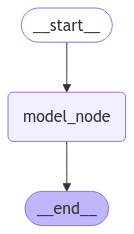

In [27]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# Adding last response to messages
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [31]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [32]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

In [33]:
for msg in messages_out_trim["messages"]:
  msg.pretty_print()

================================== Ai Message ==================================
Name: Assistant

Hi.
================================ Human Message =================================
Name: Anas

Hi.
================================== Ai Message ==================================
Name: Assistant

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Anas

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Whales are a good starting point. To broaden your knowledge of ocean mammals, here are some other fascinating groups you should definitely learn about:

**1. Dolphins and Porpoises:**

*   **Why:** Often confused with whales, they are actually *toothed whales* but are generally smaller and more agile. They are incredibly intelligent and social animals.
*   **Things to research:** Different species (b